## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [531]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [532]:
# load the data - it is available open source and online
import requests
import io

url = 'https://www.openml.org/data/get_csv/16826755/phpMYEkMl'
s = requests.get(url).content
data = pd.read_csv(io.StringIO(s.decode('utf-8')))

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [533]:
data.shape

(1309, 14)

In [534]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [535]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [536]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [537]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,title
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Miss
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON",Master
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Miss
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22,S,NaN,135,"Montreal, PQ / Chesterville, ON",Mr
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Mrs


In [538]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [539]:
# drop unnecessary variables

data.drop(['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [540]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [541]:
target = 'survived'

In [542]:
vars_cat = [var for var in data.columns if data[var].dtype == 'O']
vars_cat = vars_cat + ['pclass','sibsp','parch']

vars_num = [var for var in data.columns if var not in vars_cat and var != target]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 2
Number of categorical variables: 7


### Find missing values in variables

In [543]:
# first in numerical variables
vars_num_with_na = [var for var in vars_num if data[var].isnull().sum() > 0]
data[vars_num_with_na].isnull().mean().sort_values(ascending=False)


age     0.200917
fare    0.000764
dtype: float64

In [544]:
# now in categorical variables
vars_cat_with_na = [var for var in vars_cat if data[var].isnull().sum() > 0]
data[vars_cat_with_na].isnull().mean().sort_values(ascending=False)

cabin       0.774637
embarked    0.001528
dtype: float64

### Determine cardinality of categorical variables

<Axes: >

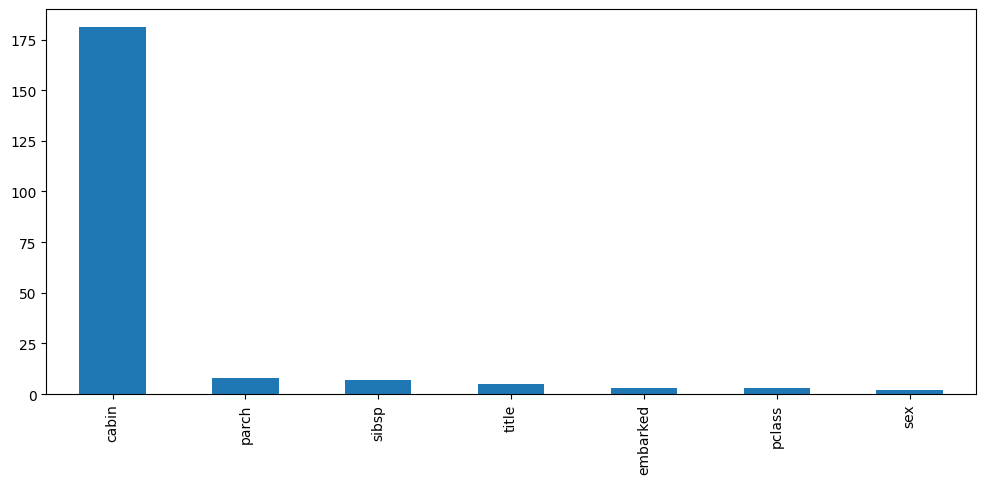

In [545]:
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Determine the distribution of numerical variables

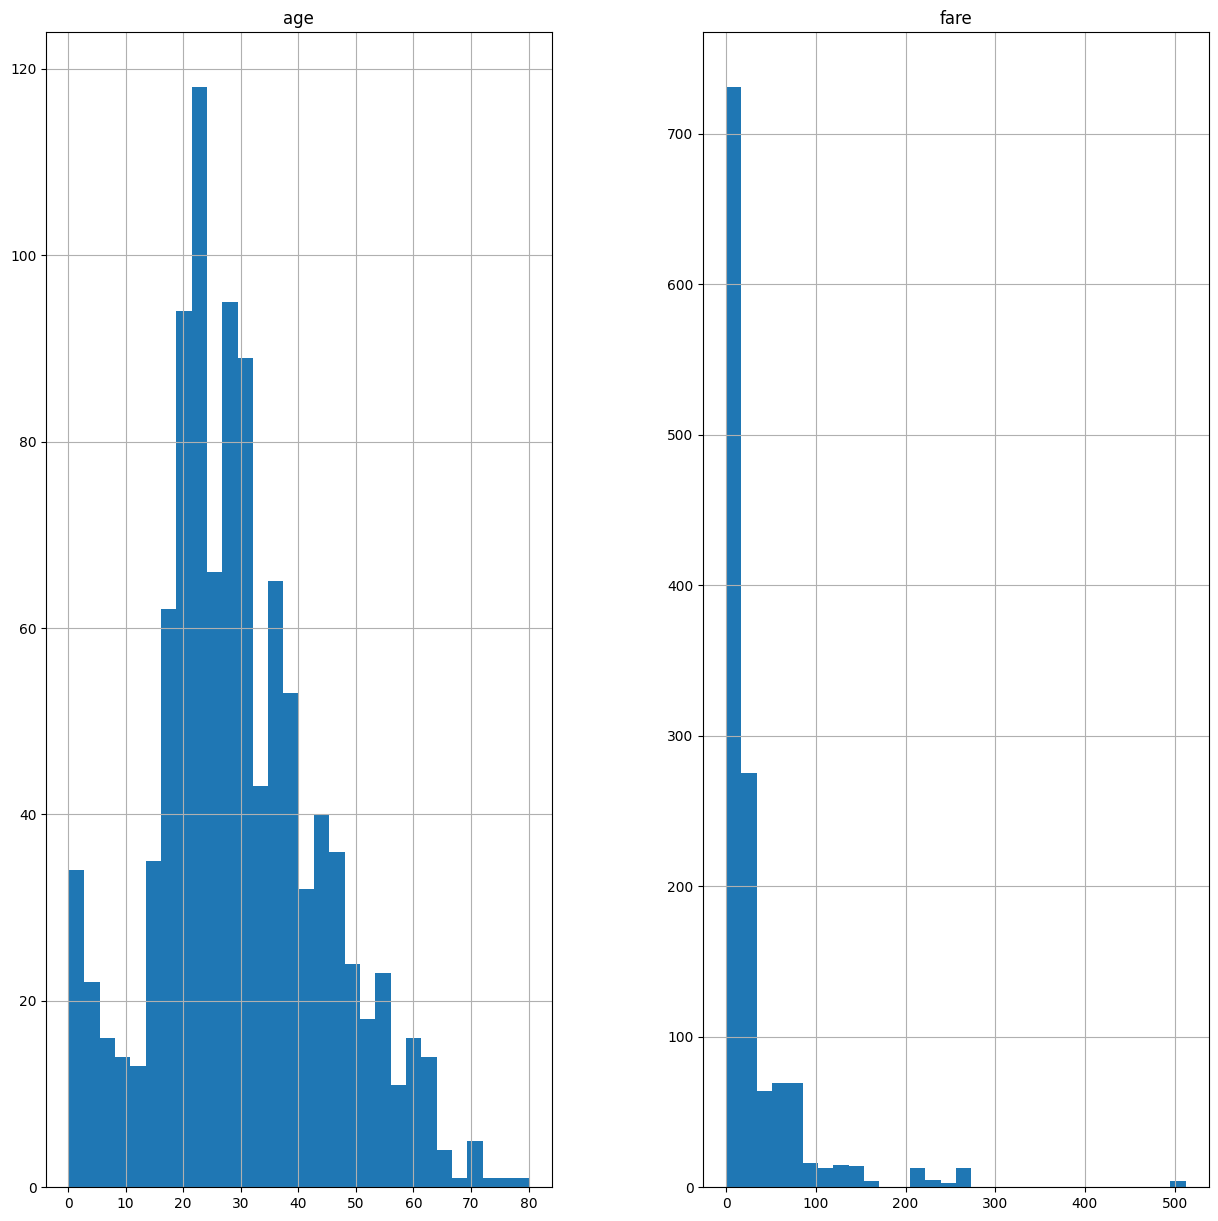

In [546]:
data[vars_num].hist(bins=30, figsize=(15,15))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [547]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [548]:
def get_letter_cabin(row):
    try:
        return list(row)[0]
    except:
        return np.nan
    
X_train['cabin'] = X_train['cabin'].apply(get_letter_cabin)
X_test['cabin'] = X_test['cabin'].apply(get_letter_cabin)
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr


In [549]:
X_train[X_train['cabin'].notna()].head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
44,1,female,41.0,0,0,134.5000,E,C,Miss
1217,3,male,19.0,0,0,7.6500,F,S,Mr
269,1,male,NaN,0,0,26.0000,A,S,Mr
322,1,female,36.0,0,0,135.6333,C,C,Miss
333,2,female,36.0,0,0,13.0000,D,S,Mrs


In [550]:
X_train['cabin'].isnull().mean()

np.float64(0.766953199617956)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [551]:
for var in vars_num_with_na:
    mean_val = X_train[var].mean()
    print(var, mean_val)

    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

X_train[vars_num_with_na].isnull().sum()

age 30.05182318668252
fare 33.744757456978974


C:\Users\mluyo\AppData\Local\Temp\ipykernel_8120\3707236707.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[var].fillna(mean_val, inplace=True)
C:\Users\mluyo\AppData\Local\Temp\ipykernel_8120\3707236707.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

age     0
fare    0
dtype: int64

In [552]:
X_test[vars_num_with_na].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [553]:
with_string_missing = [var for var in vars_cat_with_na]

In [554]:
with_string_missing

['cabin', 'embarked']

In [555]:
X_train[with_string_missing] = X_train[with_string_missing].fillna('Missing')
X_test[with_string_missing] = X_test[with_string_missing].fillna('Missing')

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [556]:
def find_frequent_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)
    return tmp[tmp > rare_perc].index

for var in vars_cat:
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    print(var, frequent_ls)
    print()
    
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

sex Index(['female', 'male'], dtype='object', name='sex')

cabin Index(['C', 'Missing'], dtype='object', name='cabin')

embarked Index(['C', 'Q', 'S'], dtype='object', name='embarked')

title Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')

pclass Index([1, 2, 3], dtype='int64', name='pclass')

sibsp Index([0, 1], dtype='int64', name='sibsp')

parch Index([0, 1, 2], dtype='int64', name='parch')



In [557]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.000000,0,0,7.9250,Missing,S,Mr,0,0
44,1,female,41.000000,0,0,134.5000,Rare,C,Miss,0,0
1072,3,male,30.051823,0,0,7.7333,Missing,Q,Mr,1,0
1130,3,female,18.000000,0,0,7.7750,Missing,S,Miss,0,0
574,2,male,29.000000,1,0,21.0000,Missing,S,Mr,0,0


In [558]:
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1139,3,male,38.000000,0,0,7.8958,Missing,S,Mr,0,0
533,2,female,21.000000,0,1,21.0000,Missing,S,Miss,0,0
459,2,male,42.000000,1,0,27.0000,Missing,S,Mr,0,0
1150,3,male,30.051823,0,0,14.5000,Missing,S,Mr,1,0
393,2,male,25.000000,0,0,31.5000,Missing,S,Mr,0,0


In [559]:
X_train.isnull().mean().sort_values(ascending=False)

pclass      0.0
sex         0.0
age         0.0
sibsp       0.0
parch       0.0
fare        0.0
cabin       0.0
embarked    0.0
title       0.0
age_na      0.0
fare_na     0.0
dtype: float64

In [560]:
X_test.isnull().mean().sort_values(ascending=False)

pclass      0.0
sex         0.0
age         0.0
sibsp       0.0
parch       0.0
fare        0.0
cabin       0.0
embarked    0.0
title       0.0
age_na      0.0
fare_na     0.0
dtype: float64

In [561]:
X_test['sex'].isnull().sum()

np.int64(0)

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [562]:
from sklearn.preprocessing import OneHotEncoder

In [563]:
for var in vars_cat:
    encoder1 = OneHotEncoder(drop='first', sparse_output=False)
    encoder2 = OneHotEncoder(drop='first', sparse_output=False)
    encoded_data_train = encoder1.fit_transform(X_train[[var]])
    encoded_data_test = encoder2.fit_transform(X_test[[var]])
    
    encoded_df_train = pd.DataFrame(
        encoded_data_train,
        columns=encoder1.get_feature_names_out([var])
    )
    encoded_df_train.index = X_train.index
    X_train = pd.concat([X_train.drop(var, axis=1), encoded_df_train], axis=1, ignore_index=False)

    encoded_df_test = pd.DataFrame(
    encoded_data_test,
    columns=encoder2.get_feature_names_out([var])
    )
    encoded_df_test.index = X_test.index
    X_test = pd.concat([X_test.drop(var, axis=1), encoded_df_test], axis=1, ignore_index=False)

In [564]:
X_train.head()

,age,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare,pclass_2,pclass_3,sibsp_1,sibsp_Rare,parch_1,parch_2,parch_Rare
1118,25.000000,7.9250,0,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
44,41.000000,134.5000,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1072,30.051823,7.7333,1,0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1130,18.000000,7.7750,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
574,29.000000,21.0000,0,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [565]:
X_test.head()

,age,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare,pclass_2,pclass_3,sibsp_1,sibsp_Rare,parch_1,parch_2,parch_Rare
1139,38.000000,7.8958,0,0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
533,21.000000,21.0000,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
459,42.000000,27.0000,0,0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1150,30.051823,14.5000,1,0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
393,25.000000,31.5000,0,0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [566]:
X_train.shape

(1047, 20)

In [567]:
X_test.shape

(262, 19)

In [568]:
left_test_vars = [var for var in X_train.columns if var not in X_test.columns]
left_test_vars

['embarked_Rare']

In [569]:
X_test['embarked_Rare'] = 0

### Scale the variables

- Use the standard scaler from Scikit-learn

In [570]:
variables = [c  for c in X_train.columns]

In [571]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[variables])
X_test = scaler.transform(X_test[variables])

X_train = pd.DataFrame(X_train, columns=variables)
X_test = pd.DataFrame(X_test, columns=variables)

In [572]:
X_train.head()

,age,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare,pclass_2,pclass_3,sibsp_1,sibsp_Rare,parch_1,parch_2,parch_Rare
0,-0.403163,-0.505177,-0.494921,-0.03092,0.761042,0.551235,-0.434076,-0.319539,-0.043748,0.639650,0.869892,-0.435629,-0.275778,-0.506856,0.911274,-0.576247,-0.293427,-0.384742,-0.312225,-0.13595
1,0.873724,1.971329,-0.494921,-0.03092,-1.313987,-1.814107,2.303742,-0.319539,-0.043748,-1.563355,-1.149569,-0.435629,-0.275778,-0.506856,-1.097365,-0.576247,-0.293427,-0.384742,-0.312225,-0.13595
2,0.000000,-0.508928,2.020526,-0.03092,0.761042,0.551235,-0.434076,3.129507,-0.043748,-1.563355,0.869892,-0.435629,-0.275778,-0.506856,0.911274,-0.576247,-0.293427,-0.384742,-0.312225,-0.13595
3,-0.961801,-0.508112,-0.494921,-0.03092,-1.313987,0.551235,-0.434076,-0.319539,-0.043748,0.639650,-1.149569,-0.435629,-0.275778,-0.506856,0.911274,-0.576247,-0.293427,-0.384742,-0.312225,-0.13595
4,-0.083941,-0.249358,-0.494921,-0.03092,0.761042,0.551235,-0.434076,-0.319539,-0.043748,0.639650,0.869892,-0.435629,-0.275778,1.972948,-1.097365,1.735366,-0.293427,-0.384742,-0.312225,-0.13595


In [573]:
X_test.head()

,age,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare,pclass_2,pclass_3,sibsp_1,sibsp_Rare,parch_1,parch_2,parch_Rare
0,0.634308,-0.505748,-0.494921,-0.03092,0.761042,0.551235,-0.434076,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778,-0.506856,0.911274,-0.576247,-0.293427,-0.384742,-0.312225,-0.13595
1,-0.722385,-0.249358,-0.494921,-0.03092,-1.313987,0.551235,-0.434076,-0.319539,-0.043748,0.63965,-1.149569,-0.435629,-0.275778,1.972948,-1.097365,-0.576247,-0.293427,2.599145,-0.312225,-0.13595
2,0.953530,-0.131965,-0.494921,-0.03092,0.761042,0.551235,-0.434076,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778,1.972948,-1.097365,1.735366,-0.293427,-0.384742,-0.312225,-0.13595
3,0.000000,-0.376534,2.020526,-0.03092,0.761042,0.551235,-0.434076,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778,-0.506856,0.911274,-0.576247,-0.293427,-0.384742,-0.312225,-0.13595
4,-0.403163,-0.043920,-0.494921,-0.03092,0.761042,0.551235,-0.434076,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778,1.972948,-1.097365,-0.576247,-0.293427,-0.384742,-0.312225,-0.13595


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [574]:
logistic_regression_model = LogisticRegression(C=0.0005, random_state=0)

In [575]:
logistic_regression_model.fit(X_train,y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [576]:
pred_class_train = logistic_regression_model.predict(X_train)
pred_prob_train = logistic_regression_model.predict_proba(X_train)[:,1]

print('The ROC-AUC score is: {}'.format(roc_auc_score(y_train, pred_prob_train)))
print('The Accuracy is: {}'.format(accuracy_score(y_train, pred_class_train)))
print()

The ROC-AUC score is: 0.8421792890262751
The Accuracy is: 0.7039159503342884



In [577]:
pred_class_test = logistic_regression_model.predict(X_test)
pred_prob_test = logistic_regression_model.predict_proba(X_test)[:,1]

print('The ROC-AUC score is: {}'.format(roc_auc_score(y_test, pred_prob_test)))
print('The Accuracy is: {}'.format(accuracy_score(y_test, pred_class_test)))

The ROC-AUC score is: 0.8364506172839505
The Accuracy is: 0.7099236641221374


In [580]:
logistic_regression_model.classes_

array([0, 1])

In [578]:
logistic_regression_model.predict_proba(X_train)

array([[0.69728063, 0.30271937],
       [0.47513295, 0.52486705],
       [0.69626809, 0.30373191],
       ...,
       [0.60226809, 0.39773191],
       [0.56288584, 0.43711416],
       [0.51397185, 0.48602815]], shape=(1047, 2))

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

In [581]:
joblib.dump(logistic_regression_model, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']